# Predict female behavior from inferred single neuron activity

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_lin_single

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30

# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'ln'  # lin-nonlinear neural model
NRL_MDL = 'ma'  # dynamical neural model

TARGS = ['FFV_MN_60', 'FFV']
# TARGS = ['FLS_MN_60', 'FLS']

FIT_LIN = skl_fit_lin_single

In [2]:
FSTRAIN = 'data/simple/strains.csv'
FBAKER_FIT_PARAM = f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv'

FPFX_NEUR_BHV = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
FPFX_BHV_XTD = f'data/simple/behav_xtd/behav_xtd'

FSAVE = f'data/simple/mlv/neur_basic/baker_single_{NRL_MDL}_{"_".join(STRAINS).lower()}_{TARGS[0].lower()}.npy'

DFBAKER_FIT_PARAM = pd.read_csv(FBAKER_FIT_PARAM)
R_COLS_USE = [f'R_{ir}' for ir in DFBAKER_FIT_PARAM.EXPT_ID]

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [4]:
rslt = skl_fit_lin_single([FPFX_NEUR_BHV, FPFX_BHV_XTD], R_COLS_USE, TARGS, ISTRAIN, NTRAIN, NSPLIT, verbose=True)

# save r2, weights, and example predictions
save_data = {
    'r2s_train': rslt.r2_train,
    'r2s_test': rslt.r2_test,
    'w': rslt.w,
    'bias': rslt.bias,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'ntrain': NTRAIN,
}

np.save(FSAVE, np.array([save_data]))

Max train R2: 0.14820005662959998
Max test R2: 0.10997699247820487
Max train R2: 0.022164894293685105
Max test R2: 0.022662819008586615


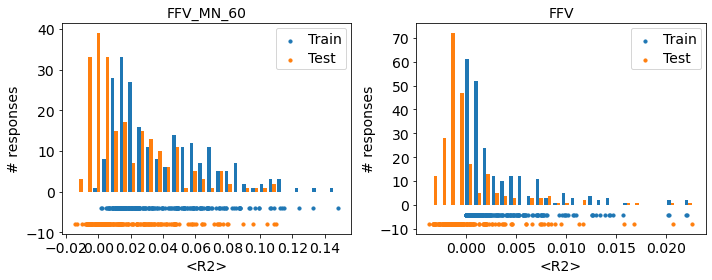

In [5]:
data = np.load(FSAVE, allow_pickle=True)[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

for targ, ax in zip(TARGS, axs):
    r2_train_means = data['r2s_train'][targ].mean(axis=0)
    r2_test_means = data['r2s_test'][targ].mean(axis=0)

    ax.hist(np.transpose([r2_train_means, r2_test_means]), bins=30)
    ax.scatter(r2_train_means, -4*np.ones(len(r2_train_means)), s=10)
    ax.scatter(r2_test_means, -8*np.ones(len(r2_test_means)), s=10)
    ax.set_title(targ)
    ax.legend(['Train', 'Test'])

    set_plot(ax, x_label='<R2>', y_label='# responses', font_size=14)

    print('Max train R2:', np.nanmax(r2_train_means))
    print('Max test R2:', np.nanmax(r2_test_means))

# Predict smoothed female velocity from trial timestamp

In [1]:
%reset -f
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30

# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'ln'  # linear-nonlinear model
NRL_MDL = 'ma'  # dynamical neural model

TARGS = ['FFV_MN_60', 'FFV']

FIT_LIN = skl_fit_ridge
FIT_KWARGS = {}

In [2]:
FSTRAIN = 'data/simple/strains.csv'

FPFX_NEUR_BHV = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
FPFX_BHV_XTD = f'data/simple/behav_xtd/behav_xtd'

FSAVE = f'data/simple/mlv/neur_basic/{"_".join(STRAINS).lower()}_{TARGS[0].lower()}_from_time.npy'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [3]:
# fit regression models
rslts = FIT_LIN(
    pfxs=[FPFX_NEUR_BHV, FPFX_BHV_XTD],
    cols_x=['T'],
    targs=TARGS,
    itr_all=ISTRAIN, 
    ntrain=NTRAIN,
    nsplit=NSPLIT,
    return_y=[0, 1],
    **FIT_KWARGS)
    
# save r2, weights, and example predictions
save_data = {
    'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
    'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
    'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
    'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'targs': TARGS,
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
}

np.save(FSAVE, np.array([save_data]))

Loading...

Split 0
Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29

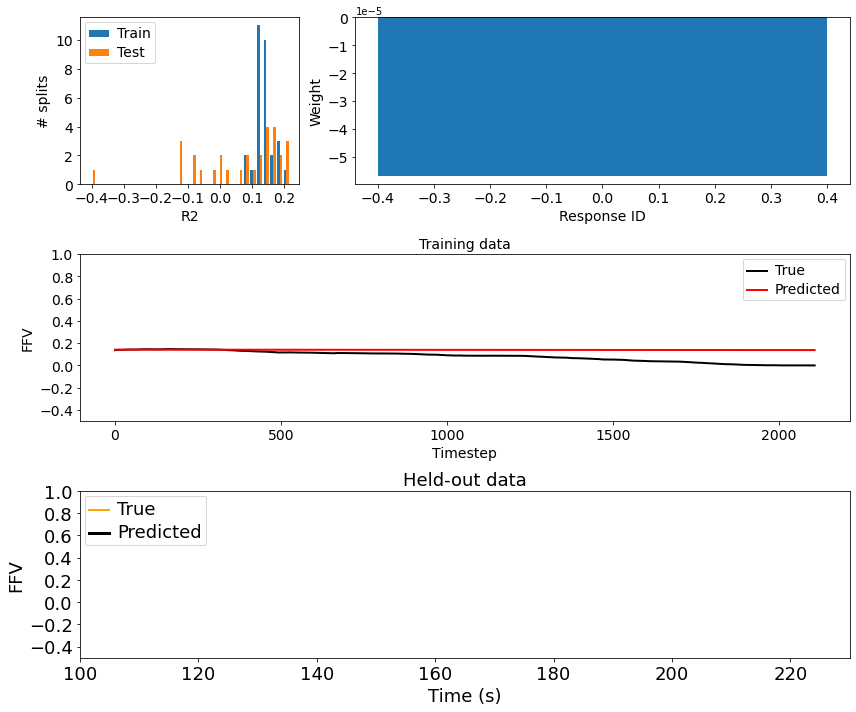

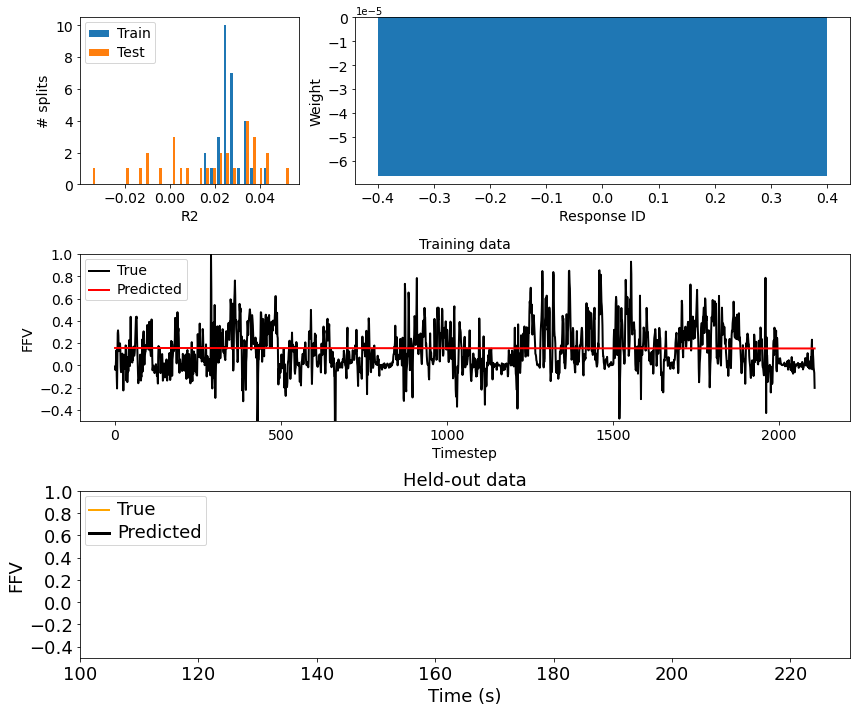

In [4]:
TRAIN_IDX_PLOT = 0
TEST_IDX_PLOT = 0

data = np.load(FSAVE, allow_pickle=True)[0]

for targ in TARGS:
    gs = gridspec.GridSpec(3, 3)

    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

    axs[0].hist(np.transpose([data['r2_train'][targ], data['r2_test'][targ]]), bins=30)
    axs[0].legend(['Train', 'Test'])
    set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

    axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0))
    set_plot(axs[1], x_label='Response ID', y_label='Weight', font_size=14)

    axs[2].plot(np.arange(len(data['ys_train'][targ][0][TRAIN_IDX_PLOT])), data['ys_train'][targ][0][TRAIN_IDX_PLOT], c='k', lw=2)
    axs[2].plot(np.arange(len(data['y_hats_train'][targ][0][TRAIN_IDX_PLOT])), data['y_hats_train'][targ][0][TRAIN_IDX_PLOT], c='r', lw=2)
    axs[2].legend(['True', 'Predicted'])
    set_plot(axs[2], y_lim=(-.5, 1), x_label='Timestep', y_label='FFV', title='Training data', font_size=14)

    axs[3].plot(np.arange(len(data['ys_test'][targ][0][TEST_IDX_PLOT]))/30.03, data['ys_test'][targ][0][TEST_IDX_PLOT], c='orange', lw=2)
    axs[3].plot(np.arange(len(data['y_hats_test'][targ][0][TEST_IDX_PLOT]))/30.03, data['y_hats_test'][targ][0][TEST_IDX_PLOT], c='k', lw=3)
    axs[3].legend(['True', 'Predicted'], loc='upper left')
    set_plot(axs[3], x_lim=(100, 230), y_lim=(-.5, 1), x_label='Time (s)', y_label='FFV', title='Held-out data', font_size=18)